In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist # type: ignore

In [3]:
tf.random.set_seed(123)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123
)

In [6]:
# Step 2: Build the training/testing pipelines
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label  # tf.one_hot(label, 10)

In [7]:
X_train, y_train = normalize_img(X_train, y_train)
X_val, y_val = normalize_img(X_val, y_val)
X_test, y_test = normalize_img(X_test, y_test)

In [8]:
# Step 3: Create the model
inp = tf.keras.layers.Input(shape=(28, 28, 1))
b = tf.keras.layers.Flatten()(inp)
b = tf.keras.layers.Dense(16, activation="relu")(b)
out = tf.keras.layers.Dense(10, activation="softmax")(b)

model = tf.keras.models.Model(inp, out)

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,730 (49.73 KB)

 Trainable params: 12,730 (49.73 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [10]:
# Step 4: Train the model
hist = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=tf.keras.callbacks.EarlyStopping(patience=2),
)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.7844 - loss: 0.7467 - val_accuracy: 0.9172 - val_loss: 0.2869
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.9230 - loss: 0.2688 - val_accuracy: 0.9275 - val_loss: 0.2509
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - accuracy: 0.9337 - loss: 0.2312 - val_accuracy: 0.9318 - val_loss: 0.2336
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - accuracy: 0.9397 - loss: 0.2089 - val_accuracy: 0.9357 - val_loss: 0.2217
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.9442 - loss: 0.1927 - val_accuracy: 0.9371 - val_loss: 0.2138
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - accuracy: 0.9477 - loss: 0.1808 - val_accuracy: 0.9382 - val_loss: 0.2078
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.9503 - loss: 0.1712 - val_accuracy: 0.9413 - val_loss: 0.2028
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - accuracy: 0.9536 -

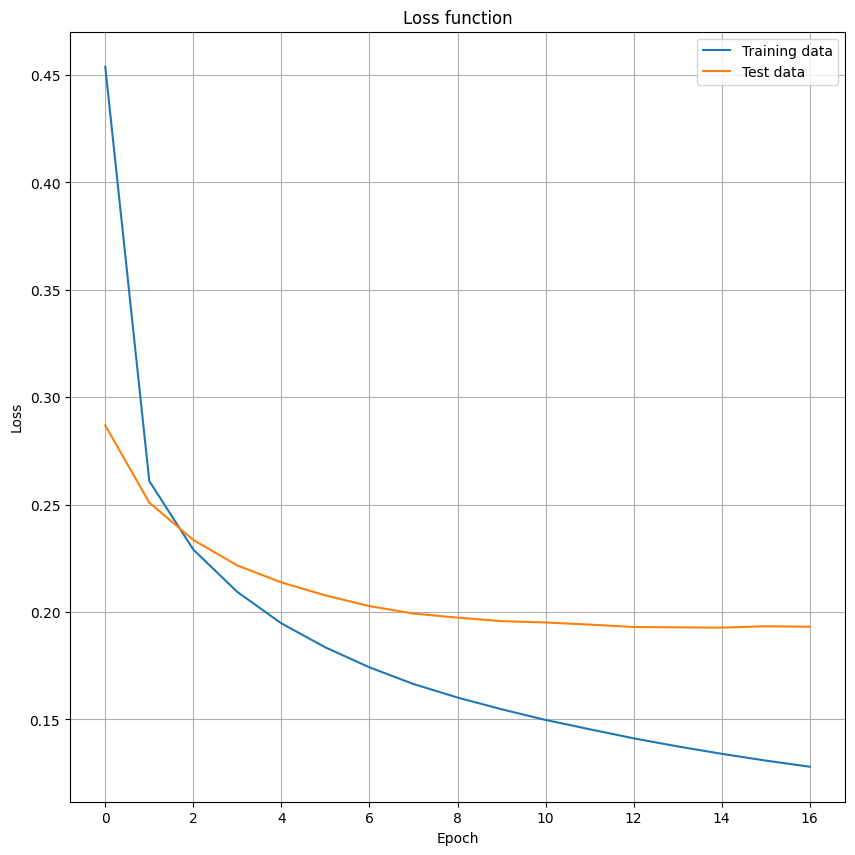

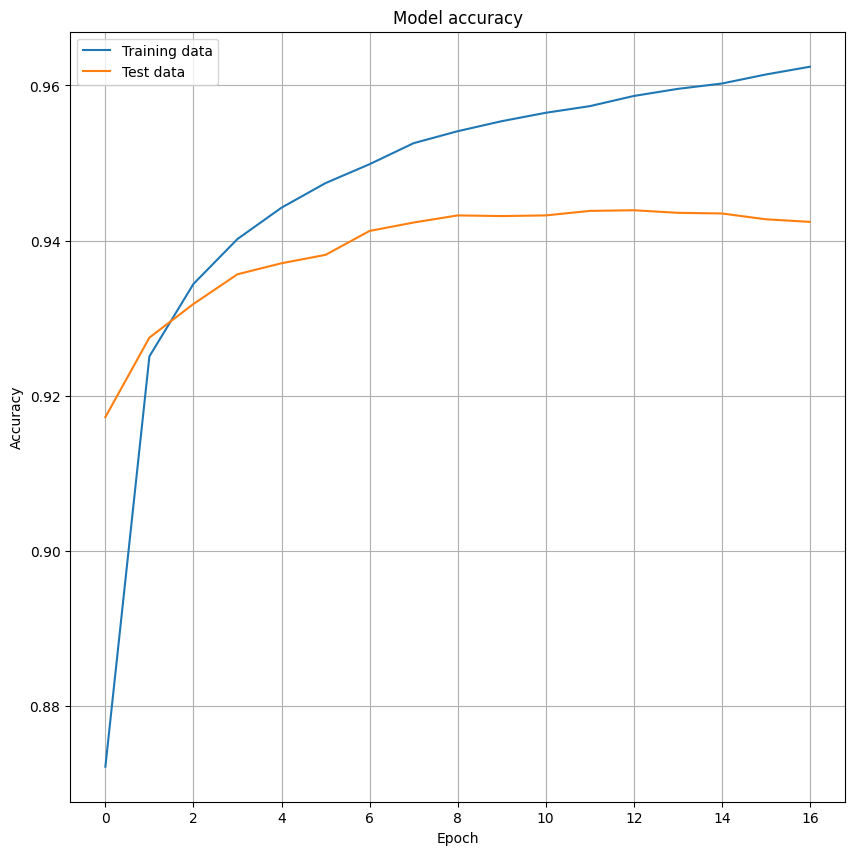

In [11]:
# Plot the training progress
fig = plt.figure(figsize=(10, 10))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss function")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend(["Training data", "Test data"])
plt.show()

fig = plt.figure(figsize=(10, 10))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.legend(["Training data", "Test data"])
plt.show()

In [12]:
# Step 5/6: Evaluate the model (we do no hyperparameter tuning here)
loss_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss: {}".format(loss_accuracy[0]))
print("Test Accuracy: {}".format(loss_accuracy[1]))

Test Loss: 0.19591501355171204
Test Accuracy: 0.9463000297546387


### Introduction to Keras tuner

In [13]:
# We install Keras tuner
%pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras_tuner as kt

In [15]:
def build_model(hp):
    """
    hp: stands for hyperparameter
    """

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Flatten())
    number_hidden_layers = hp.Int("num_layers", 1, 3)
    for i in range(number_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                hp.Int("units", min_value=16, max_value=128, step=16),
                activation="relu",
                kernel_initializer="he_normal",
            )
        )

    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
    )

    return model

In [16]:
tuner = kt.Hyperband(build_model, objective="val_acc", overwrite=True)

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

In [18]:
tuner.search(
    X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[stop_early]
)

Trial 24 Complete [00h 00m 04s]
val_acc: 0.9585833549499512

Best val_acc So Far: 0.9672499895095825
Total elapsed time: 00h 01m 29s


In [19]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [20]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

In [21]:
# Train the best model
hist = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=tf.keras.callbacks.EarlyStopping(patience=2),
)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.8701 - loss: 0.4424 - val_acc: 0.9591 - val_loss: 0.1374
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9649 - loss: 0.1160 - val_acc: 0.9666 - val_loss: 0.1129
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9769 - loss: 0.0737 - val_acc: 0.9670 - val_loss: 0.1118
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9834 - loss: 0.0523 - val_acc: 0.9720 - val_loss: 0.0989
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9878 - loss: 0.0382 - val_acc: 0.9654 - val_loss: 0.1287
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - acc: 0.9890 - loss: 0.0327 - val_acc: 0.9671 - val_loss: 0.1328


In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,848 (1.35 MB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,566 (924.09 KB)

In [23]:
# Evaluate the best model
loss_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss: {}".format(loss_accuracy[0]))
print("Test Accuracy: {}".format(loss_accuracy[1]))

Test Loss: 0.11914398521184921
Test Accuracy: 0.9678999781608582
